# Fine-tuning обученных нейросетей (5 баллов)

В этой части задания вам предстоит поработать с настоящими монстрами: сетями с почти сотней слоёв и десятками миллионов параметров. Например, такими:

![img](https://alexisbcook.github.io/assets/inception.png)
<center>googlenet inception v3</center>

Если внимателно всмотреться в картинку, можно заметить, что синим цветом обозначены свёрточные слои, красным — pooling, зелёным — конкатенация входов и т.п.

__Чем кормить такого монстра?__

Огромные нейросети обучаются на огромных массивах данных. В компьютерном зрении таких несколько, но самый популярный из них [ImageNet](http://image-net.org/). В этой выборке более миллиона изображений.

Задача этой сети состоит в классификации каждого изображение в один из 1000 классов. Вот они:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

classes = pickle.load(open('./drive/My Drive/lab_4/classes.pkl','rb'))
print(classes[::100])

['tench, Tinca tinca', 'black swan, Cygnus atratus', 'Tibetan terrier, chrysanthemum dog', 'tiger beetle', "academic gown, academic robe, judge's robe", 'cliff dwelling', 'hook, claw', 'paper towel', 'slot, one-armed bandit', 'water tower']


## Зоопарк нейросетей в keras

Если вы дошли до этого задания, значит вы уже знакомы с библиотекой keras. Так вот, в ней кроме всего прочего, есть зоопарк предобученных нейросетей: [__`keras.applications`__](https://keras.io/applications/).

Ниже пример кода, который загружает обученную модель с картинки выше.

### Внимание
InceptionV3 требует много памяти для работы. Если ваш ПК начинает зависать,
* закройте всё кроме jupyter и браузера с одной вкладкой;
* если не помогло, загрузите эту тетрадку в [google colab](https://colab.research.google.com/) и работайте там.

Ещё можно попробовать заменить `zoo.InceptionV3` на `zoo.MobileNet`. В этом случае вам придётся исправить и предобработку картинок.

In [3]:
import keras, keras.layers as L
import keras.applications as zoo

model = zoo.InceptionV3(include_top=True, weights='imagenet')

model.summary()

Using TensorFlow backend.


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
from skimage.transform import resize
def predict_top10(img):
    img = resize(img, (299, 299), mode='reflect')
    assert img.min() >= 0.0 and img.max() <= 1.0
    plt.imshow(img)
    plt.show()

    img_preprocessed = zoo.inception_v3.preprocess_input(img[None] * 255)
    probs = model.predict(img_preprocessed)[0]
    labels = probs.argsort()[-1:-10:-1]

    print('top-10 classes:')
    for l in labels:
        print('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

--2020-05-24 21:49:41--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.26.4.67, 104.26.5.67, 2606:4700:20::681a:543, ...
Connecting to cdn.com.do (cdn.com.do)|104.26.4.67|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2020-05-24 21:49:41--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.26.4.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0s      

2020-05-24 21:49:41 (106 MB/s) - ‘img.jpg’ saved [51048/51048]



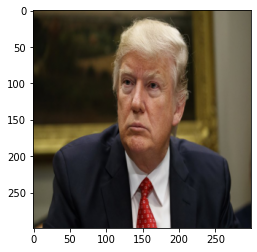

top-10 classes:
0.2136	suit
0.0652	groom
0.0255	Windsor tie
0.0128	wig
0.0121	oboe
0.0099	academic gown
0.0069	notebook
0.0065	bow tie
0.0056	mortarboard


In [5]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg
predict_top10(plt.imread('img.jpg'))

## Dogs Vs Cats

А теперь попробуем построить классификатор, который отличает изображение кошки от собаки. 

![img](https://dingo.care2.com/pictures/greenliving/1203/1202163.large.jpg)

## sklearn way

В вашем распоряжении есть предобученная сеть InceptionV3. Ваша задача — обучить классификатор из sklearn (на ваш выбор), который будет отличать котов от собак, используя __активации нейронной сети в качестве признаков__.

Для начала, прочитайте данные и сформируйте для вашего классификатора обучающую и тестовую выборки в пропорции 4:1. 

В вашем распоряжении всего 25 000 изображений различного размера, все в формате JPEG. Все картинки лежат в папке __`./train`__. Изображения кошек имеют название вида `./train/cat.*.jpg`, собак — `./train/dog.*.jpg`.

In [0]:
from PIL import Image

import glob

In [0]:
# прочитайте данные и вычислите признаки

data = []
for f in glob.glob('./drive/My Drive/lab_4/PetImages/Cat/*.jpg')[:2000]:
    img = resize(np.array(Image.open(f).convert('RGB')), (299, 299))
    data.append(img)

In [0]:
for f in glob.glob('./drive/My Drive/lab_4/PetImages/Dog/*.jpg')[:2000]:
    img = resize(np.array(Image.open(f).convert('RGB')), (299, 299))
    data.append(img)

In [0]:
data = np.array(data)

__ПРИМЕЧАНИЕ__ 
У меня всё крашилось при считывании изображений из-за нехватки памяти (даже в колабе), поэтому пришлось подобрать оптимальное значение длины выборки, когда этого не происходило

Для каждой картинки вычислите признаки из промежуточного слоя свёрточной сети. В качестве признаком можно выбрать какой-нибудь слой или несколько слоёв сети. Попробуйте найти комбинацию слоёв, которая работает лучше всего.

[Здесь](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer) можно почитать как посчитать активацию промежуточных слоёв.

In [0]:
labels = np.hstack((np.zeros(2000), np.ones(2000)))

In [0]:
# разделите данные на обучение и тест в отношении 20k/5k
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=3200)

In [0]:
del data

In [14]:
len(model.layers)

313

In [0]:
intermediate_layer_model = keras.Model(inputs=model.input, outputs=[model.layers[312].output])
feature_train = intermediate_layer_model.predict(X_train)
feature_test = intermediate_layer_model.predict(X_test)

Обучите поверх этих признаков классификатор из sklearn (можно попробовать несколько и выбрать лучший). Попробуйте получить AUC __хотя бы 99%__.

In [0]:
# обучите и примените классификаторы из sklearn. выберите лучшую модель по AUC.

In [16]:
feature_train.shape

(3200, 1000)

In [17]:
feature_test.shape

(800, 1000)

#### Логистическая регрессия

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
logReg = LogisticRegression().fit(feature_train, y_train)

In [20]:
from sklearn.metrics import roc_auc_score
test_roc_auc = roc_auc_score(y_test, logReg.predict(feature_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.974


#### SGD 

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
sgd = SGDClassifier().fit(feature_train, y_train)

In [23]:
from sklearn.metrics import roc_auc_score
test_roc_auc = roc_auc_score(y_test, sgd.predict(feature_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.979


#### Метод ближайших соседей 

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
knn = KNeighborsClassifier().fit(feature_train, y_train)

In [26]:
from sklearn.metrics import roc_auc_score
test_roc_auc = roc_auc_score(y_test, knn.predict(feature_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.969


#### Случайный лес

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
forest = RandomForestClassifier().fit(feature_train, y_train)

In [29]:
from sklearn.metrics import roc_auc_score
test_roc_auc = roc_auc_score(y_test, forest.predict(feature_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.996


#### Машина опорных векторов

In [0]:
from sklearn.svm import SVC

In [0]:
svc = SVC().fit(feature_train, y_train)

In [32]:
from sklearn.metrics import roc_auc_score
test_roc_auc = roc_auc_score(y_test, svc.predict(feature_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.979


In [0]:
del feature_train
del feature_test

Напишите ваши выводы о проделанной работе.


Если брать последние слои в качестве новых признаков для моделей, то получается очень хорошее качество даже без настройки параметров моделей. Вполне возможно, если бы я взяла больше данных, то полученные модели имели бы качество побольше, но даже на обучающей выборке из 3200 объектах качество близко к 100%

## Fine-tuning

Давайте попробуем добиться ещё большего качество через дообучение (fine-tuning) модели. Новая цель — получить качество лучше, чем у логистической регрессии в на признаках `InceptionV3(include_top=False)`. Вероятность ошибки - __менее 0.5%__.

__Шаг 1.__ - постройте сеть, в которой InceptionV3 "без головы" используется в качестве первого слоя. Поверх неё соорудите новую голову из `keras.layers` - она будет отличать котов от собак. Это можно сделать с помощью [общего интерфейса модели](https://keras.io/models/model/).

In [0]:
inputs = zoo.InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
flatten = L.Flatten()(inputs.output)
outputs = L.Dense(1, activation='sigmoid', name='output')(flatten)
updated_model = keras.Model(inputs=inputs.input, outputs=outputs)

__Шаг 2.__ - обучите "голову" на обучающей выборке. При этом не изменяйте веса изначальной сети. Частично обучать сеть в keras можно [__вот так__](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers).


In [0]:
for layer in updated_model.layers[:-1]:
    layer.trainable = False

In [36]:
updated_model.layers[-1].trainable

True

In [0]:
from keras.callbacks import ModelCheckpoint

weights_file = 'weights.h5'
callback = ModelCheckpoint(weights_file, monitor='val_auc_1', mode='max', save_best_only=True)

In [38]:
updated_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[keras.metrics.AUC()])
updated_model.fit(X_train, y_train, validation_split=0.3, callbacks=[callback])

Train on 2240 samples, validate on 960 samples
Epoch 1/1
2240/2240 [==============================] - 402s 180ms/step - loss: 0.6966 - auc_1: 0.9390 - val_loss: 0.1609 - val_auc_1: 0.9862


In [39]:
from sklearn.metrics import roc_auc_score
test_roc_auc = roc_auc_score(y_test, updated_model.predict(X_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.999


__Sanity check:__ После этого шага ваша модель должна уже быть сравнима по точности с моделями из задания 1.

Если всё получилось, самое время сохранить модель.

In [0]:
json_file = 'model.json'
model_json = model.to_json()

with open(json_file, 'w') as f:
  f.write(model_json)

__Шаг 3.__ "Разморозьте" несколько предыдущих слоёв модели и продолжите обучение. На этом этапе важно не переобучиться: смотрите на качество на валидации.

Если качество не улучшается, а сразу идёт вниз, попробуйте уменьшить число обучаемых слоёв или воспользуйтесь [__аугментацией данных__](https://keras.io/preprocessing/image/). In fact, попробуйте аугментацию данных даже если и без неё всё работает - иногда она творит чудеса.

In [0]:
updated_model.layers[-2].trainable = True
updated_model.layers[-4].trainable = True

In [42]:
updated_model.fit(X_train, y_train, validation_split=0.3)

Train on 2240 samples, validate on 960 samples
Epoch 1/1
2240/2240 [==============================] - 396s 177ms/step - loss: 0.1162 - auc_1: 0.9914 - val_loss: 0.2437 - val_auc_1: 0.9818


In [43]:
test_roc_auc = roc_auc_score(y_test, updated_model.predict(X_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 1.0


In [0]:
updated_model.layers[-3].trainable = True
updated_model.layers[-5].trainable = True

In [45]:
updated_model.fit(X_train, y_train, validation_split=0.3)

Train on 2240 samples, validate on 960 samples
Epoch 1/1
2240/2240 [==============================] - 394s 176ms/step - loss: 0.0557 - auc_1: 0.9965 - val_loss: 0.0647 - val_auc_1: 0.9957


In [46]:
test_roc_auc = roc_auc_score(y_test, updated_model.predict(X_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.998


__Шаг 4.__ Вычислите финальное качество.

In [67]:
from sklearn.metrics import roc_auc_score
test_roc_auc = roc_auc_score(y_test, updated_model.predict(X_test))
print('test roc auc score: {:.3}'.format(test_roc_auc))

test roc auc score: 0.999


Напишите отчёт и вознаградите себя за старания чем-нибудь.

Обучение "головы" модели позволило получить самую большую метрике auc (=0.999) по сравнению с моделями, построенными ранее. Дообучение модели на другие слоях в первый раз позволило увеличить тестовый auc до 1 (т.е. сеть правильно распознавала все тестовые изображения), однако валидационный auc уменьшился на 0,0042. На последующем обучении при добавлении ещё двух слоёв для обучения валидационный auc увеличился, но auc на тесте уменьшился :(
  
Было бы неплохо провести эксперименты на всех данных, чтобы точнее оценить метрики и точнее подстроить веса в моделях.

# Всё сделали, но азарт не прошел?

В таких случаях можно пробовать следующие техники:
* Ансамбль из нескольких предобученных нейросетей. Bagging? Stacking? Boosting? Всё что пожелаете.
* Более честный эксперимент: разделяем данные на train/__dev__/test, все сравнения делаем по dev, а test используем только в самом конце.
* Аугментировать данные картинками из интернета. Уж чего, а котиков и собачек там хватает.